In [1]:
#!/usr/bin/env python
# coding: utf-8


import numpy as np
import pandas as pd

import _pickle as cPickle
import argparse
from copy import deepcopy
import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import mean_squared_error
import time
from tqdm import tqdm

In [2]:
parser = argparse.ArgumentParser()
arg = parser.add_argument
arg('seed', type=int)
arg('--learning_rate', type=float, default=0.05)
arg('--num_leaves', type=int, default=31)
arg('--colsample_bytree', type=float, default=0.8)
arg('--subsample_freq', type=int, default=1)
arg('--subsample', type=float, default=0.8)
arg('-n_estimators', type=int, default=500)
args = parser.parse_args(args=['1'])

print(args)

Namespace(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500, num_leaves=31, seed=1, subsample=0.8, subsample_freq=1)


In [3]:
train_fe = pd.read_feather('../prepare_data/train_fe.ftr')
test_fe = pd.read_feather('../prepare_data/test_fe.ftr')

target_fe = train_fe['meter_reading']
train_fe = train_fe.drop('meter_reading', axis=1)

In [4]:
# drop_feature = ['day', 'hour', 'weekday', 'year_built_cat', 'wind_direction']
# df_dropped = df[drop_feature].copy()
# df = df.drop(drop_feature, axis=1)

X_train = train_fe.query('20160115 <= timestamp < 20160601 & site_id != 0')
X_valid = train_fe.query('20160901 <= timestamp < 20170101 & site_id != 0')
X_test = test_fe

y_train = target_fe.loc[X_train.index]
y_valid = target_fe.loc[X_valid.index]
# y_train = np.log1p(y_train)
# y_valid = np.log1p(y_valid)

X_train = X_train.drop('timestamp', axis=1)
X_valid = X_valid.drop('timestamp', axis=1)
X_test = X_test.drop('timestamp', axis=1)

# print(X_train.shape)

In [25]:
def meter_fit(meter, X_train, X_valid, y_train, y_valid, n_estimators=20000, verbose=5000, random_state=823, **params):
    model = lgb.LGBMRegressor(random_state=random_state, n_estimators=n_estimators, n_jobs=4, metric='rmse', **params)

    X_train_m = X_train.query('meter == {}'.format(meter)).drop('meter', axis=1)
    X_valid_m = X_valid.query('meter == {}'.format(meter)).drop('meter', axis=1)
    y_train_m = y_train[X_train_m.index]
    y_valid_m = y_valid[X_valid_m.index]
    
    g = X_valid_m.groupby('building_id')
    eval_names = ['train', 'valid']
    eval_set = [(X_train_m, y_train_m), (X_valid_m, y_valid_m)]
#     print(sorted(X_valid_m['building_id'].unique()))
#     for i in tqdm(sorted(X_valid_m['building_id'].unique())):
#         set_evalX = g.get_group(i)
#         eval_set.append((set_evalX, y_valid_m.loc[set_evalX.index]))
#         eval_names.append(i)

# building_idを抜いて実験する場合
#     for X, y in eval_set:
#         del X['building_id']
        
    print(X_train_m.shape)
    
    model.fit(X_train_m, y_train_m , eval_set = eval_set,#[(X_train_m, y_train_m), (X_valid_m, y_valid_m)], 
                    eval_names=eval_names, verbose=verbose, early_stopping_rounds = 50)
    return model


def meter_fit_all(meter, X_train, y_train, n_estimators, random_state=823, **params):
    print(n_estimators)
    X_train_m = X_train.query('meter == {}'.format(meter)).drop('meter', axis=1)
    y_train_m = y_train[X_train_m.index]
    
    print("meter{}".format(meter), end='')
    model = lgb.LGBMRegressor(random_state=random_state, n_estimators=n_estimators, n_jobs=4, metric='rmse', **params)
    model.fit(X_train_m,y_train_m,
             eval_set = [(X_train_m, y_train_m)], 
                    verbose=20)
    print(' done')
    return model


def meter_predict(meter, model, X_test, best_iteration, iteration_mul=1.5):
    X_test_m = X_test.query('meter == {}'.format(meter)).drop('meter', axis=1)
    g = X_test_m.groupby('building_id')
    
    y_pred = []
    for building_id in tqdm(sorted(X_test_m['building_id'].unique())):
        X_building = g.get_group(building_id)
        y_pred.append(pd.Series(model.predict(X_building, num_iteration=min(models_all[meter].n_estimators, int(best_iteration*iteration_mul))), index=X_building.index))
        
    return pd.concat(y_pred).sort_index()

In [17]:
lgb_params = {
#                     'boosting_type':'gbdt',
                    'learning_rate':args.learning_rate, 
                    'num_leaves': args.num_leaves,
#                     'max_depth':-1,
                    'colsample_bytree': args.colsample_bytree,
                    'subsample_freq':args.subsample_freq,
                    'subsample':args.subsample,
                }

In [19]:
# meter type毎に訓練
models = dict()
for i in [3,2,1,0]:
    print('meter {} start at {}'.format(i,time.ctime()))
    models[i] = meter_fit(i, X_train, X_valid, y_train, y_valid,verbose=20, random_state=args.seed, n_estimators=args.n_estimators, **lgb_params)
    

meter 3 start at Sun Jan 12 08:45:13 2020
(423155, 27)
Training until validation scores don't improve for 50 rounds.
[20]	train's rmse: 1.53032	valid's rmse: 1.80975
[40]	train's rmse: 1.33066	valid's rmse: 1.70448
[60]	train's rmse: 1.26554	valid's rmse: 1.68457
[80]	train's rmse: 1.23132	valid's rmse: 1.67938
[100]	train's rmse: 1.20784	valid's rmse: 1.67763
[120]	train's rmse: 1.1894	valid's rmse: 1.67711
[140]	train's rmse: 1.17341	valid's rmse: 1.67691
[160]	train's rmse: 1.1596	valid's rmse: 1.67712
[180]	train's rmse: 1.14795	valid's rmse: 1.67681
[200]	train's rmse: 1.13749	valid's rmse: 1.67703
[220]	train's rmse: 1.12862	valid's rmse: 1.67777
Early stopping, best iteration is:
[172]	train's rmse: 1.15288	valid's rmse: 1.67595
meter 2 start at Sun Jan 12 08:45:20 2020
(926869, 27)
Training until validation scores don't improve for 50 rounds.
[20]	train's rmse: 1.40222	valid's rmse: 1.51692
[40]	train's rmse: 1.14618	valid's rmse: 1.33706
[60]	train's rmse: 1.06068	valid's rmse

In [21]:
models[0].best_iteration_

271

In [24]:
# meter type毎に訓練(全てのデータを使う)
models_all = dict()
for i in [3, 2, 1, 0]:
    print('meter {} start at {}'.format(i,time.ctime()))
    models_all[i] = meter_fit_all(i, train_fe.drop('timestamp', axis=1), target_fe, verbose=50, random_state=args.seed, n_estimators=models[i].best_iteration_, **lgb_params)
#     models_all[i] = meter_fit_all(i, train_fe.drop('timestamp', axis=1), target_fe, random_state=args.seed, n_estimators=args.n_estimators, **lgb_params)

meter 3 start at Sun Jan 12 08:51:09 2020
172
meter3[20]	training's rmse: 1.62615
[40]	training's rmse: 1.41976
[60]	training's rmse: 1.3602
[80]	training's rmse: 1.3348
[100]	training's rmse: 1.3189
[120]	training's rmse: 1.30646
[140]	training's rmse: 1.29609
[160]	training's rmse: 1.28722
 done
meter 2 start at Sun Jan 12 08:51:21 2020
141
meter2[20]	training's rmse: 1.49605
[40]	training's rmse: 1.24287
[60]	training's rmse: 1.16907
[80]	training's rmse: 1.13707
[100]	training's rmse: 1.11744
[120]	training's rmse: 1.10362
[140]	training's rmse: 1.09268
 done
meter 1 start at Sun Jan 12 08:51:45 2020
86
meter1[20]	training's rmse: 1.37761
[40]	training's rmse: 1.11105
[60]	training's rmse: 1.02093
[80]	training's rmse: 0.982376
 done
meter 0 start at Sun Jan 12 08:52:13 2020
271
meter0[20]	training's rmse: 0.661786
[40]	training's rmse: 0.425202
[60]	training's rmse: 0.36599
[80]	training's rmse: 0.346483
[100]	training's rmse: 0.33608
[120]	training's rmse: 0.327952
[140]	training

In [30]:
# with open('../model/model_all_5_95_hokan_cleaning_50000tree_seed{}.pkl'.format(args.seed), 'wb') as f:
#     pickle.dump(models_all, f)


# meter type毎のtestの予測    
preds = list()
for i in tqdm([3,2,1,0]):
    preds.append(meter_predict(i, models_all[i], X_test, models[i].best_iteration_, iteration_mul=1))

y_preds = pd.concat(preds).sort_index()

 49%|████▉     | 159/324 [00:11<00:11, 14.81it/s]


 28%|██▊       | 141/498 [00:07<00:20, 17.50it/s]


 90%|█████████ | 449/498 [00:26<00:02, 17.46it/s]


 18%|█▊        | 252/1413 [00:23<01:47, 10.76it/s]


 31%|███       | 433/1413 [00:42<01:43,  9.45it/s]


 43%|████▎     | 603/1413 [01:00<01:23,  9.71it/s]


 55%|█████▌    | 783/1413 [01:19<01:02, 10.13it/s]


 69%|██████▉   | 974/1413 [01:39<00:47,  9.26it/s]


 80%|███████▉  | 1128/1413 [01:56<00:29,  9.58it/s]


 92%|█████████▏| 1294/1413 [02:13<00:12,  9.49it/s]


100%|██████████| 4/4 [03:41<00:00, 55.40s/it]


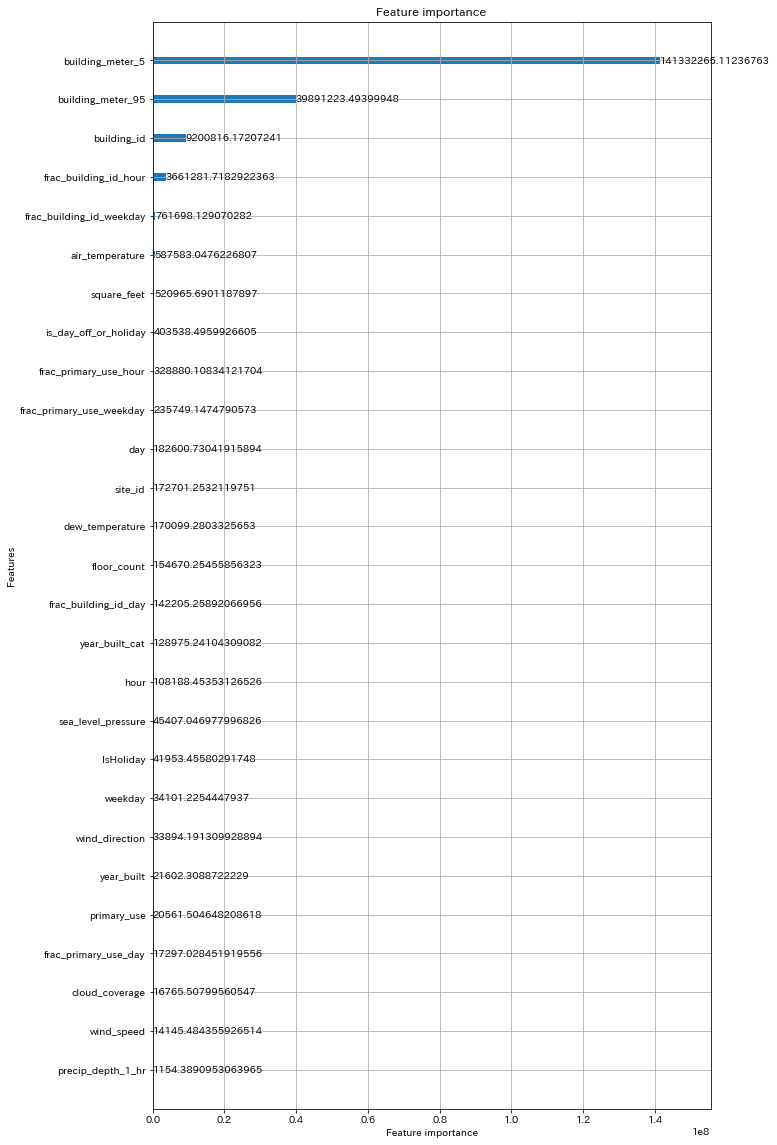

In [52]:
# lgb.plot_importance(models_all[0], importance_type='gain', figsize=(10,20))
# lgb.plot_importance(models_all[0], importance_type='split', figsize=(10,20))

In [31]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['meter_reading'] = (np.expm1(y_preds))
submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0

In [32]:
submission.to_csv('../output/solution1_seed{}.csv'.format(args.seed), index=False)

In [33]:
submission

,row_id,meter_reading
0,0,170.468167
1,1,83.210838
2,2,7.144484
3,3,309.262410
4,4,1391.940887
5,5,11.792336
6,6,141.822478
7,7,478.774656
8,8,1057.276975
9,9,390.729592


In [39]:
submission

,row_id,meter_reading
0,0,186.715860
1,1,85.910093
2,2,9.820512
3,3,299.709747
4,4,1364.735835
5,5,15.283611
6,6,118.603644
7,7,477.185972
8,8,1037.908396
9,9,393.356251


In [43]:
submission

,row_id,meter_reading
0,0,172.806893
1,1,83.174554
2,2,7.485286
3,3,305.685634
4,4,1391.720617
5,5,12.322951
6,6,139.626267
7,7,472.431927
8,8,888.670478
9,9,387.007368
